# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run1_limited",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.8852737
Average power, source: 1.0


Average magnitude, target: 0.88544965
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2520], examples_per_second: 127.0495, train_label_loss: 2.7531, 


epoch: 1, [batch: 252 / 2520], examples_per_second: 3168.9577, train_label_loss: 2.7881, 


epoch: 1, [batch: 504 / 2520], examples_per_second: 3191.1702, train_label_loss: 2.2936, 


epoch: 1, [batch: 756 / 2520], examples_per_second: 3219.7482, train_label_loss: 1.4054, 


epoch: 1, [batch: 1008 / 2520], examples_per_second: 3158.3051, train_label_loss: 1.5288, 


epoch: 1, [batch: 1260 / 2520], examples_per_second: 3176.8530, train_label_loss: 1.6357, 


epoch: 1, [batch: 1512 / 2520], examples_per_second: 3166.9360, train_label_loss: 1.3642, 


epoch: 1, [batch: 1764 / 2520], examples_per_second: 3160.3954, train_label_loss: 1.2695, 


epoch: 1, [batch: 2016 / 2520], examples_per_second: 3168.8483, train_label_loss: 1.3207, 


epoch: 1, [batch: 2268 / 2520], examples_per_second: 3179.3968, train_label_loss: 1.4364, 


epoch: 1, source_val_acc_label: 0.3878, target_val_acc_label: 0.2754, source_val_label_loss: 1.5502, target_val_label_loss: 1.8854, 


New best


epoch: 2, [batch: 1 / 2520], examples_per_second: 11.1476, train_label_loss: 1.0416, 


epoch: 2, [batch: 252 / 2520], examples_per_second: 3173.2435, train_label_loss: 1.0998, 


epoch: 2, [batch: 504 / 2520], examples_per_second: 3201.3394, train_label_loss: 1.4689, 


epoch: 2, [batch: 756 / 2520], examples_per_second: 3194.4299, train_label_loss: 1.3237, 


epoch: 2, [batch: 1008 / 2520], examples_per_second: 3176.7283, train_label_loss: 1.4108, 


epoch: 2, [batch: 1260 / 2520], examples_per_second: 3184.0726, train_label_loss: 1.4431, 


epoch: 2, [batch: 1512 / 2520], examples_per_second: 3188.7201, train_label_loss: 1.5852, 


epoch: 2, [batch: 1764 / 2520], examples_per_second: 3160.0057, train_label_loss: 1.4323, 


epoch: 2, [batch: 2016 / 2520], examples_per_second: 3183.5464, train_label_loss: 1.5152, 


epoch: 2, [batch: 2268 / 2520], examples_per_second: 3180.3564, train_label_loss: 1.5332, 


epoch: 2, source_val_acc_label: 0.4132, target_val_acc_label: 0.2991, source_val_label_loss: 1.4770, target_val_label_loss: 1.8064, 


New best


epoch: 3, [batch: 1 / 2520], examples_per_second: 11.1516, train_label_loss: 1.4111, 


epoch: 3, [batch: 252 / 2520], examples_per_second: 3157.7370, train_label_loss: 1.0747, 


epoch: 3, [batch: 504 / 2520], examples_per_second: 3177.6159, train_label_loss: 1.1258, 


epoch: 3, [batch: 756 / 2520], examples_per_second: 3184.7897, train_label_loss: 1.3803, 


epoch: 3, [batch: 1008 / 2520], examples_per_second: 3181.3716, train_label_loss: 1.1871, 


epoch: 3, [batch: 1260 / 2520], examples_per_second: 3178.3797, train_label_loss: 1.3354, 


epoch: 3, [batch: 1512 / 2520], examples_per_second: 3171.2310, train_label_loss: 1.3538, 


epoch: 3, [batch: 1764 / 2520], examples_per_second: 3164.4146, train_label_loss: 1.2856, 


epoch: 3, [batch: 2016 / 2520], examples_per_second: 3189.4858, train_label_loss: 1.1193, 


epoch: 3, [batch: 2268 / 2520], examples_per_second: 3178.0336, train_label_loss: 1.0903, 


epoch: 3, source_val_acc_label: 0.4684, target_val_acc_label: 0.3668, source_val_label_loss: 1.3745, target_val_label_loss: 1.6797, 


New best


epoch: 4, [batch: 1 / 2520], examples_per_second: 11.0896, train_label_loss: 0.8826, 


epoch: 4, [batch: 252 / 2520], examples_per_second: 3165.3063, train_label_loss: 1.1157, 


epoch: 4, [batch: 504 / 2520], examples_per_second: 3188.1980, train_label_loss: 1.1640, 


epoch: 4, [batch: 756 / 2520], examples_per_second: 3207.5801, train_label_loss: 0.9268, 


epoch: 4, [batch: 1008 / 2520], examples_per_second: 3194.2147, train_label_loss: 0.5505, 


epoch: 4, [batch: 1260 / 2520], examples_per_second: 3201.4348, train_label_loss: 1.0008, 


epoch: 4, [batch: 1512 / 2520], examples_per_second: 3210.6256, train_label_loss: 1.3788, 


epoch: 4, [batch: 1764 / 2520], examples_per_second: 3202.6747, train_label_loss: 0.8222, 


epoch: 4, [batch: 2016 / 2520], examples_per_second: 3188.2539, train_label_loss: 0.6728, 


epoch: 4, [batch: 2268 / 2520], examples_per_second: 3209.8928, train_label_loss: 1.1566, 


epoch: 4, source_val_acc_label: 0.5622, target_val_acc_label: 0.4599, source_val_label_loss: 1.2152, target_val_label_loss: 1.4781, 


New best


epoch: 5, [batch: 1 / 2520], examples_per_second: 11.0695, train_label_loss: 0.7040, 


epoch: 5, [batch: 252 / 2520], examples_per_second: 3170.0991, train_label_loss: 0.7102, 


epoch: 5, [batch: 504 / 2520], examples_per_second: 3173.0812, train_label_loss: 0.6116, 


epoch: 5, [batch: 756 / 2520], examples_per_second: 3177.1153, train_label_loss: 1.0322, 


epoch: 5, [batch: 1008 / 2520], examples_per_second: 3171.1226, train_label_loss: 0.5326, 


epoch: 5, [batch: 1260 / 2520], examples_per_second: 3177.5402, train_label_loss: 0.9602, 


epoch: 5, [batch: 1512 / 2520], examples_per_second: 3186.2934, train_label_loss: 0.6743, 


epoch: 5, [batch: 1764 / 2520], examples_per_second: 3166.5930, train_label_loss: 0.5742, 


epoch: 5, [batch: 2016 / 2520], examples_per_second: 3180.8555, train_label_loss: 0.3682, 


epoch: 5, [batch: 2268 / 2520], examples_per_second: 3191.6504, train_label_loss: 0.8658, 


epoch: 5, source_val_acc_label: 0.5711, target_val_acc_label: 0.4788, source_val_label_loss: 1.2548, target_val_label_loss: 1.4864, 


New best


epoch: 6, [batch: 1 / 2520], examples_per_second: 11.0942, train_label_loss: 0.8124, 


epoch: 6, [batch: 252 / 2520], examples_per_second: 3168.8250, train_label_loss: 0.8134, 


epoch: 6, [batch: 504 / 2520], examples_per_second: 3183.7378, train_label_loss: 0.5437, 


epoch: 6, [batch: 756 / 2520], examples_per_second: 3206.4554, train_label_loss: 0.7673, 


epoch: 6, [batch: 1008 / 2520], examples_per_second: 3177.0958, train_label_loss: 0.7494, 


epoch: 6, [batch: 1260 / 2520], examples_per_second: 3188.3686, train_label_loss: 0.5187, 


epoch: 6, [batch: 1512 / 2520], examples_per_second: 3190.7158, train_label_loss: 1.0143, 


epoch: 6, [batch: 1764 / 2520], examples_per_second: 3181.5388, train_label_loss: 0.5746, 


epoch: 6, [batch: 2016 / 2520], examples_per_second: 3184.1653, train_label_loss: 0.5055, 


epoch: 6, [batch: 2268 / 2520], examples_per_second: 3186.1673, train_label_loss: 0.5678, 


epoch: 6, source_val_acc_label: 0.5813, target_val_acc_label: 0.4892, source_val_label_loss: 1.3140, target_val_label_loss: 1.5497, 


New best


epoch: 7, [batch: 1 / 2520], examples_per_second: 11.1268, train_label_loss: 0.6034, 


epoch: 7, [batch: 252 / 2520], examples_per_second: 3177.5475, train_label_loss: 0.4023, 


epoch: 7, [batch: 504 / 2520], examples_per_second: 3190.1500, train_label_loss: 0.3226, 


epoch: 7, [batch: 756 / 2520], examples_per_second: 3190.5862, train_label_loss: 0.6961, 


epoch: 7, [batch: 1008 / 2520], examples_per_second: 3175.0515, train_label_loss: 0.1212, 


epoch: 7, [batch: 1260 / 2520], examples_per_second: 3185.2454, train_label_loss: 0.1375, 


epoch: 7, [batch: 1512 / 2520], examples_per_second: 3192.5510, train_label_loss: 0.2592, 


epoch: 7, [batch: 1764 / 2520], examples_per_second: 3193.8378, train_label_loss: 0.3136, 


epoch: 7, [batch: 2016 / 2520], examples_per_second: 3183.3437, train_label_loss: 0.3954, 


epoch: 7, [batch: 2268 / 2520], examples_per_second: 3196.5435, train_label_loss: 0.9227, 


epoch: 7, source_val_acc_label: 0.5848, target_val_acc_label: 0.4922, source_val_label_loss: 1.3849, target_val_label_loss: 1.6085, 


New best


epoch: 8, [batch: 1 / 2520], examples_per_second: 11.0446, train_label_loss: 0.3759, 


epoch: 8, [batch: 252 / 2520], examples_per_second: 3178.0172, train_label_loss: 0.5566, 


epoch: 8, [batch: 504 / 2520], examples_per_second: 3200.9500, train_label_loss: 0.5061, 


epoch: 8, [batch: 756 / 2520], examples_per_second: 3187.1911, train_label_loss: 0.4786, 


epoch: 8, [batch: 1008 / 2520], examples_per_second: 3208.1498, train_label_loss: 0.5307, 


epoch: 8, [batch: 1260 / 2520], examples_per_second: 3186.9069, train_label_loss: 0.4820, 


epoch: 8, [batch: 1512 / 2520], examples_per_second: 3187.3779, train_label_loss: 0.2160, 


epoch: 8, [batch: 1764 / 2520], examples_per_second: 3181.9487, train_label_loss: 0.0730, 


epoch: 8, [batch: 2016 / 2520], examples_per_second: 3194.5985, train_label_loss: 0.0971, 


epoch: 8, [batch: 2268 / 2520], examples_per_second: 3197.3958, train_label_loss: 0.4406, 


epoch: 8, source_val_acc_label: 0.5799, target_val_acc_label: 0.4943, source_val_label_loss: 1.5239, target_val_label_loss: 1.7626, 


New best


epoch: 9, [batch: 1 / 2520], examples_per_second: 11.1326, train_label_loss: 0.1290, 


epoch: 9, [batch: 252 / 2520], examples_per_second: 3176.6768, train_label_loss: 0.3516, 


epoch: 9, [batch: 504 / 2520], examples_per_second: 3197.9420, train_label_loss: 0.2978, 


epoch: 9, [batch: 756 / 2520], examples_per_second: 3194.1445, train_label_loss: 0.9421, 


epoch: 9, [batch: 1008 / 2520], examples_per_second: 3178.1170, train_label_loss: 0.3860, 


epoch: 9, [batch: 1260 / 2520], examples_per_second: 3202.2144, train_label_loss: 0.4152, 


epoch: 9, [batch: 1512 / 2520], examples_per_second: 3195.9687, train_label_loss: 0.4844, 


epoch: 9, [batch: 1764 / 2520], examples_per_second: 3181.7209, train_label_loss: 0.1983, 


epoch: 9, [batch: 2016 / 2520], examples_per_second: 3189.6140, train_label_loss: 0.1908, 


epoch: 9, [batch: 2268 / 2520], examples_per_second: 3197.4555, train_label_loss: 0.2599, 


epoch: 9, source_val_acc_label: 0.5813, target_val_acc_label: 0.4923, source_val_label_loss: 1.5921, target_val_label_loss: 1.8277, 


epoch: 10, [batch: 1 / 2520], examples_per_second: 11.0887, train_label_loss: 0.0821, 


epoch: 10, [batch: 252 / 2520], examples_per_second: 3184.4455, train_label_loss: 0.1841, 


epoch: 10, [batch: 504 / 2520], examples_per_second: 3191.9513, train_label_loss: 0.2897, 


epoch: 10, [batch: 756 / 2520], examples_per_second: 3198.6537, train_label_loss: 0.2651, 


epoch: 10, [batch: 1008 / 2520], examples_per_second: 3186.0048, train_label_loss: 0.2274, 


epoch: 10, [batch: 1260 / 2520], examples_per_second: 3188.9462, train_label_loss: 0.3179, 


epoch: 10, [batch: 1512 / 2520], examples_per_second: 3206.6346, train_label_loss: 0.4964, 


epoch: 10, [batch: 1764 / 2520], examples_per_second: 3202.7525, train_label_loss: 0.2104, 


epoch: 10, [batch: 2016 / 2520], examples_per_second: 3212.9925, train_label_loss: 0.2664, 


epoch: 10, [batch: 2268 / 2520], examples_per_second: 3194.5052, train_label_loss: 0.3342, 


epoch: 10, source_val_acc_label: 0.5766, target_val_acc_label: 0.4919, source_val_label_loss: 1.7271, target_val_label_loss: 1.9772, 


epoch: 11, [batch: 1 / 2520], examples_per_second: 11.1083, train_label_loss: 0.2810, 


epoch: 11, [batch: 252 / 2520], examples_per_second: 3177.6680, train_label_loss: 0.1526, 


epoch: 11, [batch: 504 / 2520], examples_per_second: 3178.9943, train_label_loss: 0.4291, 


epoch: 11, [batch: 756 / 2520], examples_per_second: 3187.7923, train_label_loss: 0.1525, 


epoch: 11, [batch: 1008 / 2520], examples_per_second: 3174.1876, train_label_loss: 0.2789, 


epoch: 11, [batch: 1260 / 2520], examples_per_second: 3192.8637, train_label_loss: 0.3084, 


epoch: 11, [batch: 1512 / 2520], examples_per_second: 3189.3585, train_label_loss: 0.1838, 


epoch: 11, [batch: 1764 / 2520], examples_per_second: 3161.2350, train_label_loss: 0.1194, 


epoch: 11, [batch: 2016 / 2520], examples_per_second: 3187.0915, train_label_loss: 0.2710, 


epoch: 11, [batch: 2268 / 2520], examples_per_second: 3200.8452, train_label_loss: 0.2639, 


epoch: 11, source_val_acc_label: 0.5813, target_val_acc_label: 0.4954, source_val_label_loss: 1.7501, target_val_label_loss: 1.9644, 


New best


epoch: 12, [batch: 1 / 2520], examples_per_second: 11.1041, train_label_loss: 0.2734, 


epoch: 12, [batch: 252 / 2520], examples_per_second: 3179.6194, train_label_loss: 0.1239, 


epoch: 12, [batch: 504 / 2520], examples_per_second: 3200.1696, train_label_loss: 0.2497, 


epoch: 12, [batch: 756 / 2520], examples_per_second: 3197.7814, train_label_loss: 0.4258, 


epoch: 12, [batch: 1008 / 2520], examples_per_second: 3195.8607, train_label_loss: 0.5263, 


epoch: 12, [batch: 1260 / 2520], examples_per_second: 3215.8041, train_label_loss: 0.2811, 


epoch: 12, [batch: 1512 / 2520], examples_per_second: 3196.0233, train_label_loss: 0.2427, 


epoch: 12, [batch: 1764 / 2520], examples_per_second: 3192.0186, train_label_loss: 0.2048, 


epoch: 12, [batch: 2016 / 2520], examples_per_second: 3197.4095, train_label_loss: 0.0885, 


epoch: 12, [batch: 2268 / 2520], examples_per_second: 3213.5626, train_label_loss: 0.3758, 


epoch: 12, source_val_acc_label: 0.5859, target_val_acc_label: 0.4919, source_val_label_loss: 1.8308, target_val_label_loss: 2.0944, 


epoch: 13, [batch: 1 / 2520], examples_per_second: 11.1670, train_label_loss: 0.1173, 


epoch: 13, [batch: 252 / 2520], examples_per_second: 3183.7388, train_label_loss: 0.3229, 


epoch: 13, [batch: 504 / 2520], examples_per_second: 3184.6130, train_label_loss: 0.0278, 


epoch: 13, [batch: 756 / 2520], examples_per_second: 3183.8996, train_label_loss: 0.6217, 


epoch: 13, [batch: 1008 / 2520], examples_per_second: 3190.9021, train_label_loss: 0.1578, 


epoch: 13, [batch: 1260 / 2520], examples_per_second: 3204.4665, train_label_loss: 0.2352, 


epoch: 13, [batch: 1512 / 2520], examples_per_second: 3207.6755, train_label_loss: 0.1311, 


epoch: 13, [batch: 1764 / 2520], examples_per_second: 3167.6605, train_label_loss: 0.2152, 


epoch: 13, [batch: 2016 / 2520], examples_per_second: 3202.6866, train_label_loss: 0.1106, 


epoch: 13, [batch: 2268 / 2520], examples_per_second: 3194.5403, train_label_loss: 0.0758, 


epoch: 13, source_val_acc_label: 0.5870, target_val_acc_label: 0.4942, source_val_label_loss: 1.8713, target_val_label_loss: 2.1122, 


epoch: 14, [batch: 1 / 2520], examples_per_second: 11.1505, train_label_loss: 0.1086, 


epoch: 14, [batch: 252 / 2520], examples_per_second: 3180.4808, train_label_loss: 0.5511, 


epoch: 14, [batch: 504 / 2520], examples_per_second: 3189.1490, train_label_loss: 0.0693, 


epoch: 14, [batch: 756 / 2520], examples_per_second: 3179.9185, train_label_loss: 0.0704, 


epoch: 14, [batch: 1008 / 2520], examples_per_second: 3182.5170, train_label_loss: 0.1105, 


epoch: 14, [batch: 1260 / 2520], examples_per_second: 3202.6284, train_label_loss: 0.4658, 


epoch: 14, [batch: 1512 / 2520], examples_per_second: 3199.0688, train_label_loss: 0.2468, 


epoch: 14, [batch: 1764 / 2520], examples_per_second: 3206.1495, train_label_loss: 0.0123, 


epoch: 14, [batch: 2016 / 2520], examples_per_second: 3192.9310, train_label_loss: 0.0917, 


epoch: 14, [batch: 2268 / 2520], examples_per_second: 3177.2910, train_label_loss: 0.1178, 


epoch: 14, source_val_acc_label: 0.5828, target_val_acc_label: 0.4904, source_val_label_loss: 1.9017, target_val_label_loss: 2.1953, 


epoch: 15, [batch: 1 / 2520], examples_per_second: 11.0996, train_label_loss: 0.1230, 


epoch: 15, [batch: 252 / 2520], examples_per_second: 3177.5410, train_label_loss: 0.1199, 


epoch: 15, [batch: 504 / 2520], examples_per_second: 3197.0207, train_label_loss: 0.0977, 


epoch: 15, [batch: 756 / 2520], examples_per_second: 3187.2685, train_label_loss: 0.0048, 


epoch: 15, [batch: 1008 / 2520], examples_per_second: 3175.1668, train_label_loss: 0.2042, 


epoch: 15, [batch: 1260 / 2520], examples_per_second: 3200.0435, train_label_loss: 0.0825, 


epoch: 15, [batch: 1512 / 2520], examples_per_second: 3203.2758, train_label_loss: 0.1279, 


epoch: 15, [batch: 1764 / 2520], examples_per_second: 3179.9538, train_label_loss: 0.5370, 


epoch: 15, [batch: 2016 / 2520], examples_per_second: 3195.1275, train_label_loss: 0.3488, 


epoch: 15, [batch: 2268 / 2520], examples_per_second: 3197.7618, train_label_loss: 0.0780, 


epoch: 15, source_val_acc_label: 0.5872, target_val_acc_label: 0.4978, source_val_label_loss: 2.0061, target_val_label_loss: 2.2715, 


New best


epoch: 16, [batch: 1 / 2520], examples_per_second: 11.0456, train_label_loss: 0.0384, 


epoch: 16, [batch: 252 / 2520], examples_per_second: 3178.1150, train_label_loss: 0.1380, 


epoch: 16, [batch: 504 / 2520], examples_per_second: 3182.6019, train_label_loss: 0.3578, 


epoch: 16, [batch: 756 / 2520], examples_per_second: 3217.0176, train_label_loss: 0.2732, 


epoch: 16, [batch: 1008 / 2520], examples_per_second: 3193.2451, train_label_loss: 0.0941, 


epoch: 16, [batch: 1260 / 2520], examples_per_second: 3197.8836, train_label_loss: 0.1265, 


epoch: 16, [batch: 1512 / 2520], examples_per_second: 3195.8353, train_label_loss: 0.0720, 


epoch: 16, [batch: 1764 / 2520], examples_per_second: 3194.0261, train_label_loss: 0.0559, 


epoch: 16, [batch: 2016 / 2520], examples_per_second: 3187.8390, train_label_loss: 0.2857, 


epoch: 16, [batch: 2268 / 2520], examples_per_second: 3193.3784, train_label_loss: 0.1043, 


epoch: 16, source_val_acc_label: 0.5819, target_val_acc_label: 0.4947, source_val_label_loss: 2.0261, target_val_label_loss: 2.3531, 


epoch: 17, [batch: 1 / 2520], examples_per_second: 11.1533, train_label_loss: 0.0540, 


epoch: 17, [batch: 252 / 2520], examples_per_second: 3165.2335, train_label_loss: 0.1055, 


epoch: 17, [batch: 504 / 2520], examples_per_second: 3191.7599, train_label_loss: 0.0679, 


epoch: 17, [batch: 756 / 2520], examples_per_second: 3187.0025, train_label_loss: 0.0907, 


epoch: 17, [batch: 1008 / 2520], examples_per_second: 3151.9858, train_label_loss: 0.1666, 


epoch: 17, [batch: 1260 / 2520], examples_per_second: 3170.5444, train_label_loss: 0.0958, 


epoch: 17, [batch: 1512 / 2520], examples_per_second: 3173.0384, train_label_loss: 0.0511, 


epoch: 17, [batch: 1764 / 2520], examples_per_second: 3175.3711, train_label_loss: 0.0564, 


epoch: 17, [batch: 2016 / 2520], examples_per_second: 3183.6818, train_label_loss: 0.2392, 


epoch: 17, [batch: 2268 / 2520], examples_per_second: 3190.1663, train_label_loss: 0.0373, 


epoch: 17, source_val_acc_label: 0.5903, target_val_acc_label: 0.4958, source_val_label_loss: 1.9739, target_val_label_loss: 2.2431, 


epoch: 18, [batch: 1 / 2520], examples_per_second: 11.0679, train_label_loss: 0.0472, 


epoch: 18, [batch: 252 / 2520], examples_per_second: 3176.0015, train_label_loss: 0.0449, 


epoch: 18, [batch: 504 / 2520], examples_per_second: 3175.1126, train_label_loss: 0.0598, 


epoch: 18, [batch: 756 / 2520], examples_per_second: 3179.5941, train_label_loss: 0.3017, 


epoch: 18, [batch: 1008 / 2520], examples_per_second: 3183.4819, train_label_loss: 0.3896, 


epoch: 18, [batch: 1260 / 2520], examples_per_second: 3190.0968, train_label_loss: 0.0551, 


epoch: 18, [batch: 1512 / 2520], examples_per_second: 3186.0796, train_label_loss: 0.1144, 


epoch: 18, [batch: 1764 / 2520], examples_per_second: 3177.0942, train_label_loss: 0.0498, 


epoch: 18, [batch: 2016 / 2520], examples_per_second: 3188.7076, train_label_loss: 0.1453, 


epoch: 18, [batch: 2268 / 2520], examples_per_second: 3193.8889, train_label_loss: 0.2105, 


epoch: 18, source_val_acc_label: 0.5815, target_val_acc_label: 0.4946, source_val_label_loss: 2.0795, target_val_label_loss: 2.3914, 


epoch: 19, [batch: 1 / 2520], examples_per_second: 11.1467, train_label_loss: 0.0303, 


epoch: 19, [batch: 252 / 2520], examples_per_second: 3181.7317, train_label_loss: 0.0163, 


epoch: 19, [batch: 504 / 2520], examples_per_second: 3181.4452, train_label_loss: 0.0953, 


epoch: 19, [batch: 756 / 2520], examples_per_second: 3186.5679, train_label_loss: 0.0338, 


epoch: 19, [batch: 1008 / 2520], examples_per_second: 3176.8055, train_label_loss: 0.1437, 


epoch: 19, [batch: 1260 / 2520], examples_per_second: 3188.1418, train_label_loss: 0.3269, 


epoch: 19, [batch: 1512 / 2520], examples_per_second: 3187.0335, train_label_loss: 0.1734, 


epoch: 19, [batch: 1764 / 2520], examples_per_second: 3165.4188, train_label_loss: 0.0227, 


epoch: 19, [batch: 2016 / 2520], examples_per_second: 3190.4200, train_label_loss: 0.0040, 


epoch: 19, [batch: 2268 / 2520], examples_per_second: 3190.3783, train_label_loss: 0.0155, 


epoch: 19, source_val_acc_label: 0.5902, target_val_acc_label: 0.4943, source_val_label_loss: 2.1195, target_val_label_loss: 2.3967, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

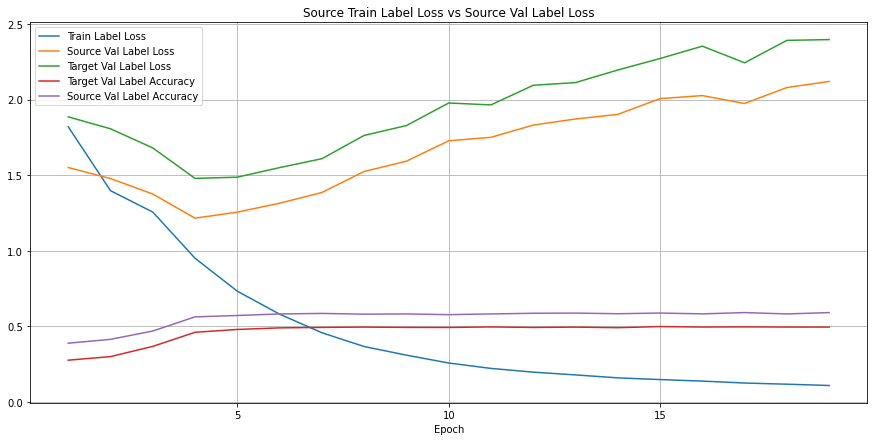

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

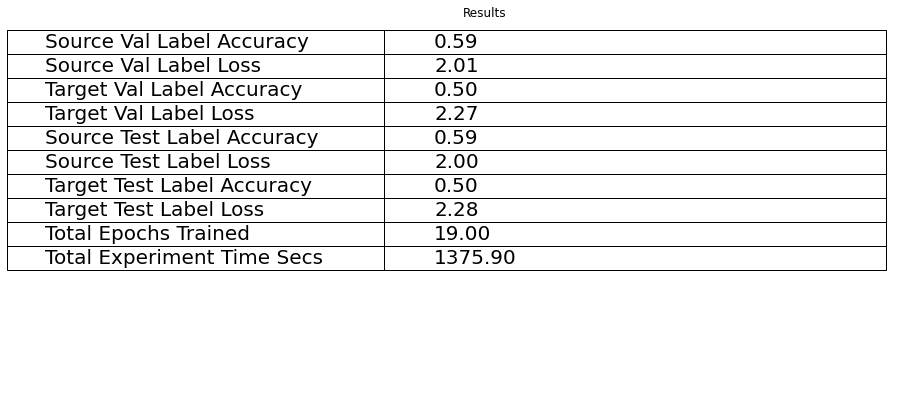

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

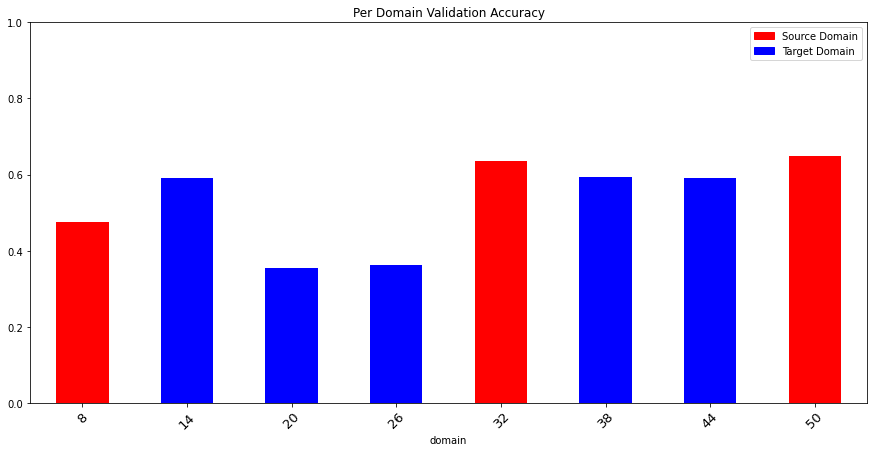

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5891493055555556 Target Test Label Accuracy: 0.5005729166666667
Source Val Label Accuracy: 0.5872395833333334 Target Val Label Accuracy: 0.4978125


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run1_limited", "parameters": {"experiment_name": "tuned_1v2:oracle.run1_limited", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [